In [13]:
import os
import cv2
import random
import shutil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [14]:
train_dir = 'images/train'
testing_dir = 'images/testing'

In [15]:
def data_generators(TRAINING_DIR,TESTING_DIR):

  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.3,
                                   zoom_range = 0.3,
                                   horizontal_flip = True,
                                   vertical_flip = True)

  train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = 64,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))

  testing_datagen = ImageDataGenerator( rescale = 1.0/255.)
    
  testing_generator = testing_datagen.flow_from_directory(TESTING_DIR,
                                                    batch_size = 64,
                                                    class_mode = 'categorical', 
                                                    target_size = (150,150))

  return train_generator, testing_generator

In [16]:
train_generator,testing_generator = data_generators(train_dir, testing_dir)

Found 440 images belonging to 5 classes.
Found 185 images belonging to 5 classes.


In [17]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D

In [18]:
base_model=MobileNet(weights='imagenet',include_top=False,input_shape = (150,150, 3))
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(216,activation='relu')(x)
preds=Dense(5,activation='softmax')(x)

In [19]:
len(base_model.layers)

86

In [20]:
for layer in base_model.layers[:50]:
    layer.trainable = False
for layer in base_model.layers[50:86]:
    layer.trainable = True

In [21]:
model_mobilenet=Model(inputs=base_model.input,outputs=preds)

In [22]:
SGD = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=False)


In [23]:
from tensorflow.keras.optimizers import SGD as LegacySGD

SGD = LegacySGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.SGD.

In [ ]:
model_mobilenet.compile(optimizer=SGD,loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') > 0.85:
            print("\nReached 85% accuracy so cancelling training!")
            self.model.stop_training = True

In [27]:
callbacks = myCallback()

In [28]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('val_acc') > 0.85:
            print("\nReached 85% validation accuracy, so cancelling training!")
            self.model.stop_training = True


In [29]:
history = model_mobilenet.fit(train_generator,
                    epochs=50,
                          verbose=1,callbacks=[callbacks])

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [30]:
results = model_mobilenet.evaluate(testing_generator, batch_size=128)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [31]:
model_mobilenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 75, 75, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 75, 75, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 75, 75, 32)        128   

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create a simple Sequential model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=100))
model.add(Dense(units=10, activation='softmax'))

# Compile the model (you can use any suitable loss and optimizer)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Train the model (you should replace this with your actual training data)
# model.fit(x_train, y_train, epochs=10)

# Save the model in HDF5 format
model.save("my_model.h5")

# Convert the model to JSON
model_json = model.to_json()

# Save the JSON representation to a file
with open("faceskindiseases.json", 'w') as json_file:
    json_file.write(model_json)


C:\Users\ACER\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def confussion_matrix(test_true, test_pred, test_class):
    cm = confusion_matrix(test_true, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class)
    fig, ax = plt.subplots(figsize=(15,15))
    disp.plot(ax=ax,cmap=plt.cm.Blues)
    plt.show()

3/3 [==============================] - 6s 1s/step


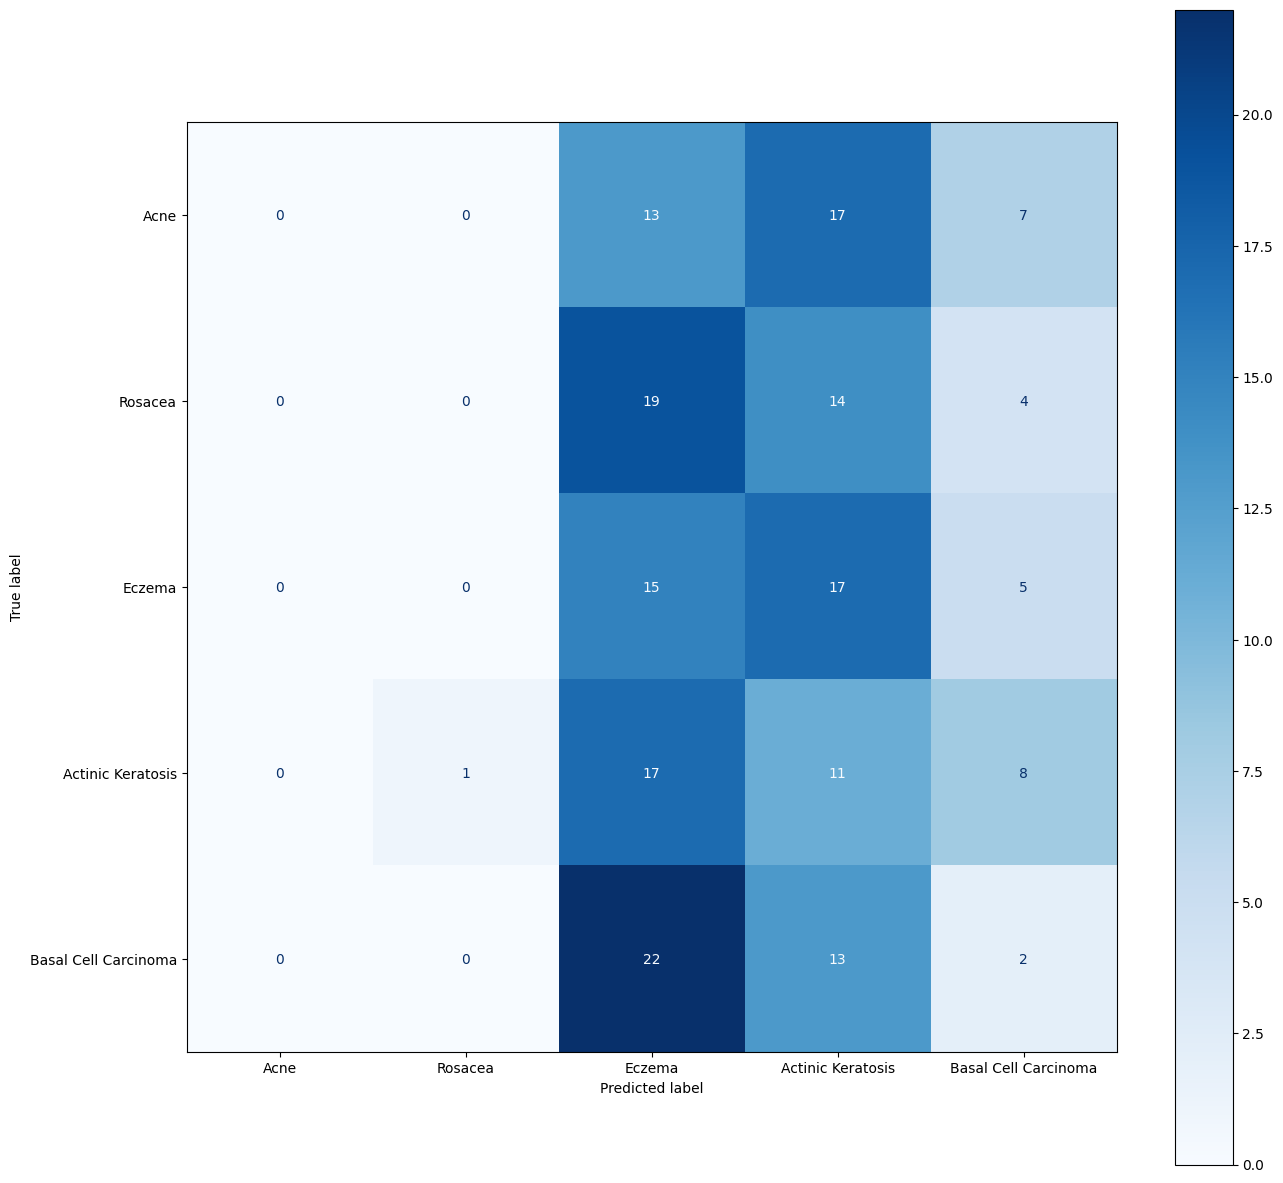

In [44]:
testing_pred_raw = model_mobilenet.predict(testing_generator)
testing_pred = np.argmax(testing_pred_raw, axis=1)
testing_true = testing_generator.classes
testing_class = ["Acne", "Rosacea", "Eczema", "Actinic Keratosis", "Basal Cell Carcinoma" ]
confussion_matrix(testing_true, testing_pred, testing_class)

In [45]:
def cluster_segmentation(img, k=5):
  pixel_values = img.reshape((-1, 3))
  pixel_values = np.float32(pixel_values)

  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

  _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  centers=np.uint8(centers)
  labels = labels.flatten()
  segmented_img = centers[labels.flatten()]
  segmented_img = segmented_img.reshape(img.shape)
  masked_img =  np.copy(img)
  masked_img = masked_img.reshape((-1, 3))
  cluster = 2
  masked_img[labels==cluster] = [0, 0, 0]
  masked_img = masked_img.reshape(img.shape)

  return masked_img

In [46]:
def segmentation_generators(TRAINING_DIR,TESTING_DIR, PREPROCESSING_IMG):

  train_datagen = ImageDataGenerator(preprocessing_function=PREPROCESSING_IMG,
                                   rescale = 1./255.,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.3,
                                   zoom_range = 0.3,
                                   horizontal_flip = True,
                                   vertical_flip = True)

  train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = 64,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))

  
 
  testing_datagen = ImageDataGenerator(preprocessing_function=PREPROCESSING_IMG,
                                       rescale = 1.0/255.)
    
  testing_generator = testing_datagen.flow_from_directory(TESTING_DIR,
                                                    batch_size = 64,
                                                    class_mode = 'categorical', 
                                                    target_size = (150,150))

  return train_generator, testing_generator

In [48]:
train_generator, testing_generator = segmentation_generators(train_dir, testing_dir, cluster_segmentation)

Found 440 images belonging to 5 classes.
Found 185 images belonging to 5 classes.


In [50]:
history = model_mobilenet.fit(train_generator,
                    epochs=30)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [51]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploads = files.upload()

n_files = len(uploads)
fig = plt.figure(figsize=(2, 2 * n_files))

for i, filename in enumerate(uploads):
  img = image.load_img(
      filename,
      target_size=(224, 224)
  )
  x = image.img_to_array(img)/255
  x = np.expand_dims(x, axis=0)

  predict = model.predict(x)
  class_prediction = np.argmax(predict)
  prediction = class_dict[class_prediction]
  
  
  ax = fig.add_subplot(n_files, 1, i+1)
  ax.imshow(img)
  ax.set_title(prediction)
  ax.axis(False)
  print('percentage:')
  print(predict)

ModuleNotFoundError: No module named 'google.colab'